In [23]:
%matplotlib inline
import os, sys, gc
import shutil
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import entropy as scent
from matplotlib import gridspec
import matplotlib.image as mpimg

from scipy.stats import pearsonr as pr

import collections

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def ent_fn(X):
    """Return row-wise entropy of X (samples by probs)"""
    ents = np.empty(X.shape[0])
    for i, row in enumerate(X):
        ents[i] = scent(row)
    return ents

def cross_entropy_loss(Q, P):
    """Q are inputs (CNN; samples by category), P are targets (samples by categories). """
    n, c = Q.shape
    print('{0} samples, {1} classes'.format(n, c))
    logQ = np.log(Q)
    loss = - np.sum(logQ * P)
    return loss / n
    

loadDir = 'base_predictions'
saveDir = 'figures'
# raw bins
bins = np.load('{0}/human_bincounts.npy'.format(loadDir))

#raw probabilities
humans = bins / np.sum(bins, axis = 1)[:, np.newaxis]

# smoothed probabilities
humans_smoothed = (bins +1) / np.sum(bins, axis = 1)[:, np.newaxis]

ordered_filenames = np.load('{0}/decoded_test_filename_order.npy'.format(loadDir))

labels = ['P', 'A', 'B', 'C', 'De', 'Do', 'F', 'H', 'S', 'T']

im_dir = '/home/battleday/Academic/Berkeley/Superman/local/images/train_set_combined'

In [15]:

test_files = os.listdir('{0}/test/'.format(loadDir))
print(test_files)
test_files = sorted([p for p in test_files if p[-4:] == '.npz'])
print(test_files)

['resnext_29_8x64d_test.npz', 'resnet_preact_bottleneck_164_test.npz', 'densenet_BC_100_12_test.npz', 'vgg_15_BN_64_test.npz', 'pyramidnet_basic_110_270_test.npz', 'wrn_28_10_test.npz', 'shake_shake_26_2x64d_SSI_cutout16_test.npz', 'resnet_basic_110_test.npz']
['densenet_BC_100_12_test.npz', 'pyramidnet_basic_110_270_test.npz', 'resnet_basic_110_test.npz', 'resnet_preact_bottleneck_164_test.npz', 'resnext_29_8x64d_test.npz', 'shake_shake_26_2x64d_SSI_cutout16_test.npz', 'vgg_15_BN_64_test.npz', 'wrn_28_10_test.npz']


In [16]:
test_dict = collections.OrderedDict()
predictions = []
for m in test_files:
    raw = np.load('{0}/test/{1}'.format(loadDir, m))
    model = m.split('.')[0]
    test_dict[model] = {}
    predictions.append(raw['probs'])
#    for prop in raw.keys(): 
#        test_dict[model][prop] = raw[prop]
ensemble = np.mean(np.array(predictions), axis = 0)
print(ensemble.shape, ensemble[0], ensemble[:].sum())

(10000, 10) [  1.98514294e-06   2.36292726e-06   3.15334250e-06   9.99972880e-01
   2.91738888e-06   6.00185740e-06   4.57979922e-06   2.70124337e-06
   1.59628644e-06   1.89841319e-06] 10000.0


In [30]:
testNumber = 4
testModel = test_files[testNumber]
testLoss = cross_entropy_loss(predictions[testNumber], humans)
print(testModel, testLoss)
ensembleLoss = cross_entropy_loss(ensemble, humans)
print('ensemble', ensembleLoss)

10000 samples, 10 classes
resnext_29_8x64d_test.npz 0.469985918132
10000 samples, 10 classes
ensemble 0.406809295457


In [7]:
def sba(model_predictions, human_predictions):
    """Returns second best accuracy score (of wrong images)"""
    total = model_predictions.shape[0]
    right = 0
    for i in np.arange(total):
        msb = np.argsort(model_predictions[i])[-2] # takes second best
        lab = np.argmax(human_predictions[i])
        right += (msb == lab)
    return right / total
accuracies = []
sbas = []
test_dict = collections.OrderedDict()
for m in test_files:
    raw = np.load('{0}/test/{1}'.format(loadDir, m))
    model = m.split('.')[0]
    print(model)
    test_dict[model] = {}
    for prop in raw.keys(): 
        test_dict[model][prop] = raw[prop]
    test_dict[model]['entropy'] = ent_fn(test_dict[model]['probs'])
    print('max ent: ', np.max(test_dict[model]['entropy']),
         'min ent: ', np.min(test_dict[model]['entropy']))
    test_dict[model]['wrong_idx'] = np.where(np.argmax(test_dict[model]['probs'], axis=1) != test_dict[model]['labels'])[0]
    test_dict[model]['sba'] = sba(test_dict[model]['probs'][test_dict[model]['wrong_idx']], humans[test_dict[model]['wrong_idx']])
    test_dict[model]['accuracy'] = 1 - (np.shape(test_dict[model]['wrong_idx'])[0] / 10000)
    print('num errors:', np.shape(test_dict[model]['wrong_idx']), 'accuracy: ', test_dict[model]['accuracy'])
    print('sba: ', test_dict[model]['sba'])
    accuracies.append(test_dict[model]['accuracy'])
    sbas.append(test_dict[model]['sba'])
human_ent = ent_fn(humans_smoothed)
print('max human ent: ', np.max(human_ent),
     'min human ent: ', np.min(human_ent))   
print(test_dict.keys())

densenet_BC_100_12_test
max ent:  1.52360081673 min ent:  2.96002024974e-12
num errors: (438,) accuracy:  0.9562
sba:  0.641552511416
pyramidnet_basic_110_270_test
max ent:  1.69210278988 min ent:  1.25211101931e-07
num errors: (379,) accuracy:  0.9621
sba:  0.622691292876
resnet_basic_110_test
max ent:  1.40216708183 min ent:  2.98569328983e-13
num errors: (594,) accuracy:  0.9406
sba:  0.631313131313
resnet_preact_bottleneck_164_test
max ent:  1.62994360924 min ent:  8.932707872e-12
num errors: (572,) accuracy:  0.9428
sba:  0.664335664336
resnext_29_8x64d_test
max ent:  1.74878668785 min ent:  4.98849210828e-08
num errors: (354,) accuracy:  0.9646
sba:  0.652542372881
shake_shake_26_2x64d_SSI_cutout16_test
max ent:  1.59434366226 min ent:  4.08348493908e-11
num errors: (270,) accuracy:  0.973
sba:  0.622222222222
vgg_15_BN_64_test
max ent:  1.58164250851 min ent:  8.34983360232e-10
num errors: (682,) accuracy:  0.9318
sba:  0.634897360704
wrn_28_10_test
max ent:  2.02981567383 min e

(-0.34231537703831916, 0.40653659601849201)

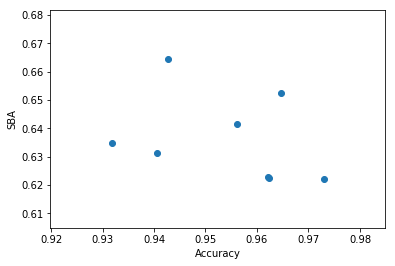

In [8]:
plt.scatter(accuracies, sbas)
plt.xlabel('Accuracy')
plt.ylabel('SBA')
pr(accuracies, sbas)

In [9]:
averageEnt = []
for key, value in train_dict.items():
    averageEnt.append(value['entropy'])
averageEnt = np.mean(averageEnt, axis=0)
print(averageEnt.shape)

num_ims = 5
top = np.argsort(averageEnt)
print(top.shape)

(50000,)
(50000,)


num models:  8


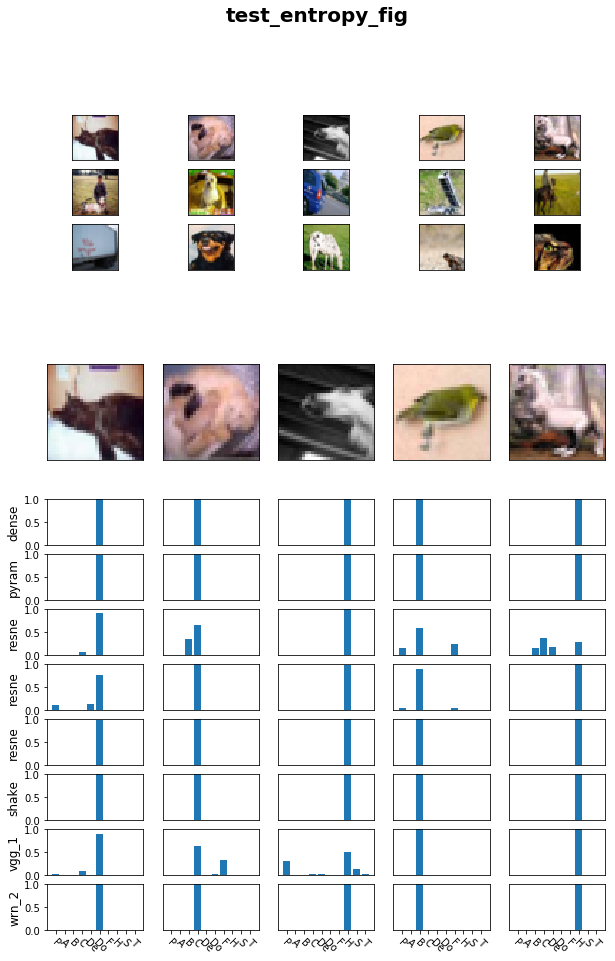

In [10]:
def fig_fn(title, save_path, ims, models,
           num_ims, added_rows = 4,
           base_rows = 3):
    """still a bunch of other things defined above
    that aren't in here"""
    extended_ims = ims.copy()[-(num_ims * (added_rows -1)):][::-1]
    ims = ims.copy()[-num_ims:][::-1]
    
    num_models = len(models.keys())
    print('num models: ', num_models)
    
    fig = plt.figure(figsize=((num_ims) * 2, added_rows + num_models + base_rows)) 
    gs = gridspec.GridSpec(added_rows + num_models + base_rows, num_ims)

    for i in np.arange(num_ims * (added_rows - 1)):
        r, c = np.unravel_index(i, (added_rows - 1, num_ims))
        #print(r, c)
        ax = plt.subplot(gs[r, c])
        im = extended_ims[i]
        im_name = str(im)
        ax.set_xticks([])
        ax.set_yticks([])
        img = mpimg.imread(im_dir + '/' + im_name + '.png')
        mpimg.imsave(saveDir + '/' + im_name + '.png', img)
        #ax_im_b.set_title('High certainty image', fontsize = 20)
        ax.imshow(img)


    fig.suptitle(title, fontsize = 20, fontweight='bold')
    for i in np.arange(num_ims):
        im = ims[i]
        ax_im_b = plt.subplot(gs[added_rows: added_rows + 3, i]) # size of im
        im_name_b = str(im)
        ax_im_b.xaxis.set_ticklabels([])
        ax_im_b.set_xticks([])
        ax_im_b.set_yticks([])
        #ax_im_b.set_title(labels[0], fontsize = 12)
        ax_im_b.yaxis.set_ticklabels([])
        img_b = mpimg.imread(im_dir + '/' + im_name_b + '.png')
        #ax_im_b.set_title('High certainty image', fontsize = 20)
        ax_im_b.imshow(img_b)

        for m, model in enumerate(models.keys()):
            im_guesses = models[model]['probs'][im]
            #print(im_guesses)
            ax = plt.subplot(gs[added_rows + 3 + m, i])
            ax.bar(np.arange(10), im_guesses) #, align = 'left')
            ax.set_xlim([-1, 10])
            ax.set_ylim([0, 1]) 

            if ax.is_first_col():
                ax.set_ylabel(model[:5], fontsize = 12)
            else:
                ax.yaxis.set_ticks([])

            ax.xaxis.set_ticks([])

            if ax.is_last_row():
                ax.xaxis.set_ticks(np.arange(len(labels)))
                ax.xaxis.set_ticklabels(labels)
                plt.xticks(rotation = -45, ha='center')

    plt.savefig(save_path + '/' + title + '.png')

fig_fn('test_entropy_fig', saveDir, top, train_dict, 
      5)   